## Importing the relevant libraries

In [36]:
import torch, time
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [37]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name()
    device = torch.device("cuda")
    print("Device Name:", device_name)
    print("GPU Device:", device)

Device Name: Tesla T4
GPU Device: cuda


In [38]:
# Defining a custom list of image transformations to make models more robust and generic
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.Resize((244,244)),
    transforms.CenterCrop((244,244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
transform

Compose(
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.3)
    Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(244, 244))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

## Loading the dataset

In [39]:
data_dir = "/kaggle/input/animal-image-classification-dataset/Animals"
dataset = datasets.ImageFolder(root=data_dir,transform=transform)

## Data Exploration

In [40]:
len(dataset)

3000

In [41]:
train_set, validation_set = random_split(dataset,lengths=[0.8,0.2])

In [42]:
len(train_set), len(validation_set)

(2400, 600)

In [43]:
train_loader = DataLoader(dataset=train_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")
val_loader = DataLoader(dataset=validation_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")

In [44]:
for images, labels in train_loader:
    break

In [45]:
images.shape

torch.Size([32, 3, 244, 244])

In [46]:
labels.shape

torch.Size([32])

## Visualizing images within the dataset

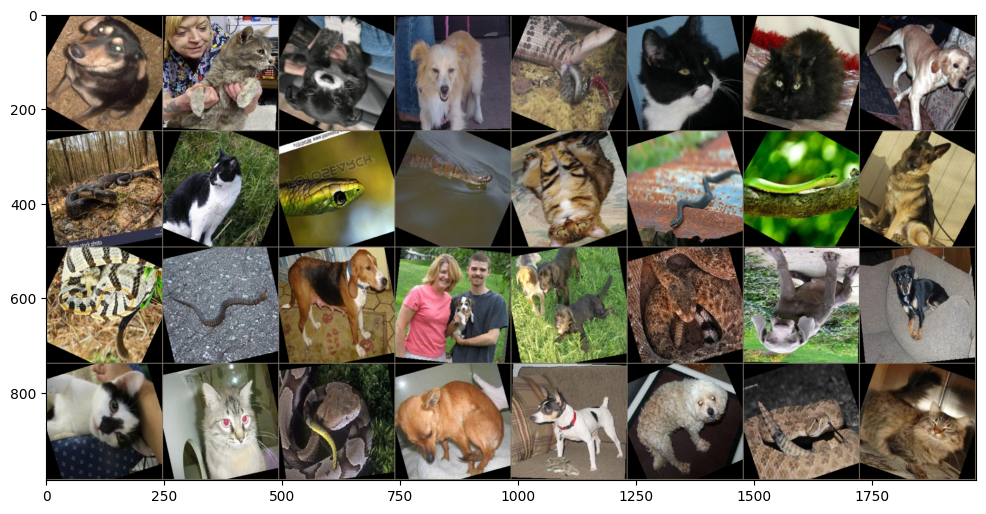

In [47]:
images_grid = make_grid(images,nrow=8)
inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_img_grid = inv_normalize(images_grid)

plt.figure(figsize=(12,8))
plt.imshow(np.transpose(inv_img_grid.numpy(),(1,2,0)));

## Model Training & Evaluation

In [49]:
class ConvolutionalNeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1) # 121,121,32
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1) # 59,59,64
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1) # 28,28,128
        self.fc1 = nn.Linear(in_features=28*28*128,out_features=128)
        self.fc2 = nn.Linear(in_features=128,out_features=64)
        self.fc3 = nn.Linear(in_features=64,out_features=32)
        self.fc4 = nn.Linear(in_features=32,out_features=3)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,28*28*128) # flattening operation
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X,dim=1)

In [50]:
torch.manual_seed(33)
model = ConvolutionalNeuralNetwork().cuda()
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
)

In [51]:
next(model.parameters()).is_cuda

True

In [52]:
total_parameters = 0

for param in model.parameters():
    print(param.numel())
    total_parameters += param.numel()
    
print("Total parameters of CNN model:", total_parameters)

864
32
18432
64
73728
128
12845056
128
8192
64
2048
32
96
3
Total parameters of CNN model: 12948867


In [53]:
torch.cuda.memory_allocated()

420889600

In [54]:
torch.cuda.memory_reserved()

2160066560

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [56]:
start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    val_correct = 0
    
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        batch_no += 1
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
         
        optimizer.zero_grad() # Reset the gradients to zero for each mini-training batch
        loss.backward() # Compute gradient of the loss by performing backpropagation
        optimizer.step() # Update the model parameters
        
        if batch_no % 10 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
        
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():    
        for batch_no, (X_val, y_val) in enumerate(val_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
        
    loss = criterion(y_pred,y_val)
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())

print(f"Total time elapsed in CNN model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 10 -> Loss: 1.0967949628829956
Epoch 1 Batch 20 -> Loss: 1.0796438455581665
Epoch 1 Batch 30 -> Loss: 1.033923625946045
Epoch 1 Batch 40 -> Loss: 0.9638921618461609
Epoch 1 Batch 50 -> Loss: 0.9849458932876587
Epoch 1 Batch 60 -> Loss: 0.8080176115036011
Epoch 1 Batch 70 -> Loss: 0.9161390662193298
Epoch 2 Batch 10 -> Loss: 0.7370179891586304
Epoch 2 Batch 20 -> Loss: 0.847137987613678
Epoch 2 Batch 30 -> Loss: 0.8198192715644836
Epoch 2 Batch 40 -> Loss: 1.1230521202087402
Epoch 2 Batch 50 -> Loss: 0.8679054379463196
Epoch 2 Batch 60 -> Loss: 0.6093988418579102
Epoch 2 Batch 70 -> Loss: 0.6497383117675781
Epoch 3 Batch 10 -> Loss: 0.9043243527412415
Epoch 3 Batch 20 -> Loss: 0.7297338247299194
Epoch 3 Batch 30 -> Loss: 0.7705105543136597
Epoch 3 Batch 40 -> Loss: 0.7054708003997803
Epoch 3 Batch 50 -> Loss: 0.8234962224960327
Epoch 3 Batch 60 -> Loss: 0.8454567193984985
Epoch 3 Batch 70 -> Loss: 0.6149664521217346
Epoch 4 Batch 10 -> Loss: 0.9564656019210815
Epoch 4 Batc

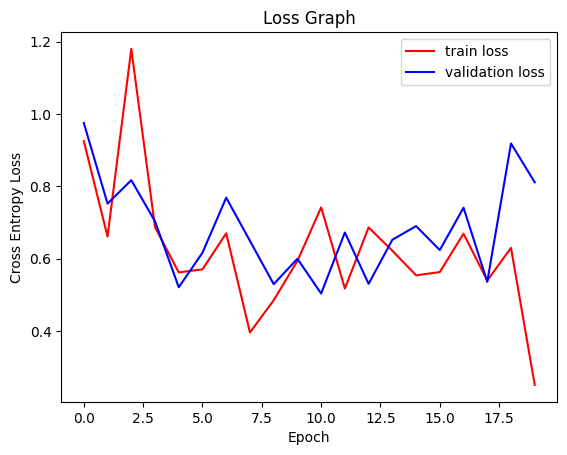

In [57]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [58]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
val_accuracies = [x/len(validation_set) for x in val_correct_predictions]

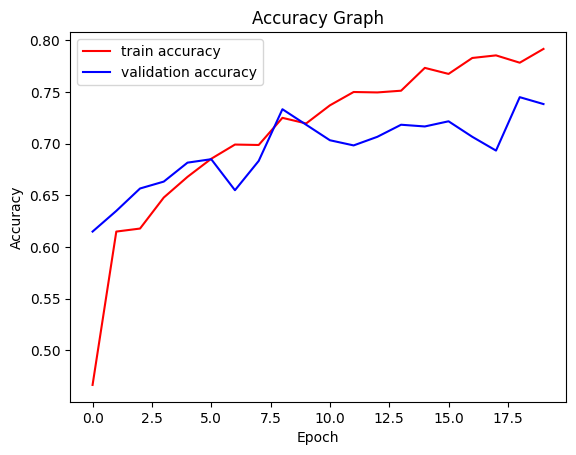

In [59]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(val_accuracies,'b',label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [60]:
torch.save(model,'cat_dog_snake_image_classifier.pt')

## Fine-tuning the pretrained models

### Alex Net

In [108]:
alexnet = models.alexnet(pretrained=True)
alexnet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [109]:
total_alexnet_params = 0

for param in alexnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_alexnet_params += param.numel()
    
print("Total AlexNet model parameters:", total_alexnet_params)

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
4096000
1000
Total AlexNet model parameters: 61100840


In [110]:
alexnet.classifier = nn.Sequential(
    nn.Linear(9216,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,3),
    nn.LogSoftmax(dim=1)
)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [113]:
alexnet = alexnet.cuda()
next(alexnet.parameters()).is_cuda

True

In [114]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=alexnet.parameters(),lr=0.001)

start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    val_correct = 0
        
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        batch_no += 1
        y_pred = alexnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
         
        optimizer.zero_grad() # Reset the gradients to zero for each mini-training batch
        loss.backward() # Compute gradient of the loss by performing backpropagation
        optimizer.step() # Update the model parameters
        
        if batch_no % 10 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
        
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
        
    with torch.no_grad():    
        for batch_no, (X_val, y_val) in enumerate(val_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = alexnet(X_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
        
    loss = criterion(y_pred,y_val)
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())

print(f"Total time elapsed in AlexNet model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 10 -> Loss: 0.7684159874916077
Epoch 1 Batch 20 -> Loss: 0.4169243574142456
Epoch 1 Batch 30 -> Loss: 0.19964593648910522
Epoch 1 Batch 40 -> Loss: 0.563651978969574
Epoch 1 Batch 50 -> Loss: 0.2128673940896988
Epoch 1 Batch 60 -> Loss: 0.23491507768630981
Epoch 1 Batch 70 -> Loss: 0.38420867919921875
Epoch 2 Batch 10 -> Loss: 0.20666995644569397
Epoch 2 Batch 20 -> Loss: 0.09208174049854279
Epoch 2 Batch 30 -> Loss: 0.21749649941921234
Epoch 2 Batch 40 -> Loss: 0.32430845499038696
Epoch 2 Batch 50 -> Loss: 0.1665267050266266
Epoch 2 Batch 60 -> Loss: 0.24886174499988556
Epoch 2 Batch 70 -> Loss: 0.22103461623191833
Epoch 3 Batch 10 -> Loss: 0.06550332903862
Epoch 3 Batch 20 -> Loss: 0.3940071165561676
Epoch 3 Batch 30 -> Loss: 0.618364691734314
Epoch 3 Batch 40 -> Loss: 0.29785388708114624
Epoch 3 Batch 50 -> Loss: 0.16315005719661713
Epoch 3 Batch 60 -> Loss: 0.17948642373085022
Epoch 3 Batch 70 -> Loss: 0.19137927889823914
Epoch 4 Batch 10 -> Loss: 0.15884850919246674


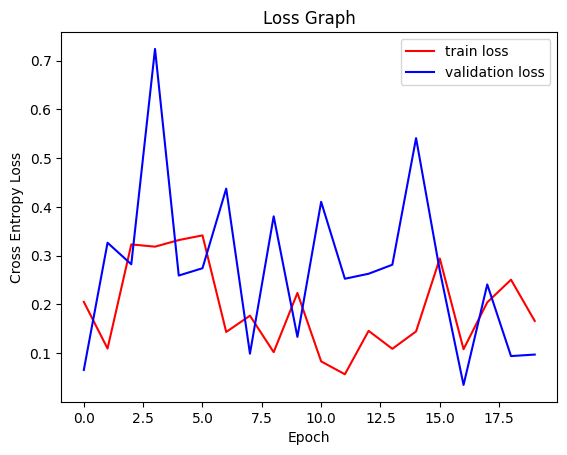

In [115]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [116]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
val_accuracies = [x/len(validation_set) for x in val_correct_predictions]

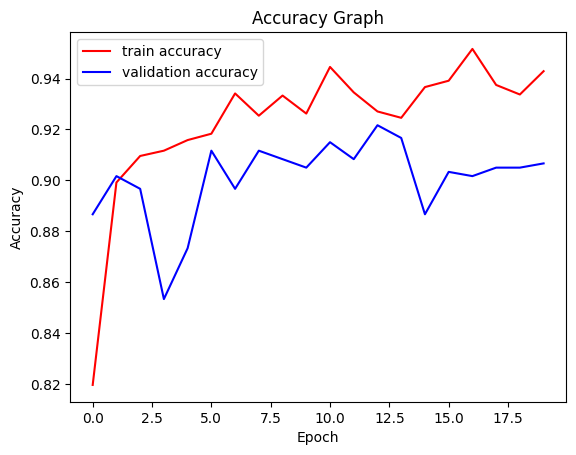

In [117]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(val_accuracies,'b',label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

### Dense Net 121

In [118]:
densenet121 = models.densenet121(pretrained=True)
densenet121

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 112MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [119]:
total_densenet_params = 0

for param in densenet121.parameters():
    param.requires_grad = False
    print(param.numel())
    total_densenet_params += param.numel()
    
print("Total parameters of DenseNet121 model:",total_densenet_params)

9408
64
64
64
64
8192
128
128
36864
96
96
12288
128
128
36864
128
128
16384
128
128
36864
160
160
20480
128
128
36864
192
192
24576
128
128
36864
224
224
28672
128
128
36864
256
256
32768
128
128
16384
128
128
36864
160
160
20480
128
128
36864
192
192
24576
128
128
36864
224
224
28672
128
128
36864
256
256
32768
128
128
36864
288
288
36864
128
128
36864
320
320
40960
128
128
36864
352
352
45056
128
128
36864
384
384
49152
128
128
36864
416
416
53248
128
128
36864
448
448
57344
128
128
36864
480
480
61440
128
128
36864
512
512
131072
256
256
32768
128
128
36864
288
288
36864
128
128
36864
320
320
40960
128
128
36864
352
352
45056
128
128
36864
384
384
49152
128
128
36864
416
416
53248
128
128
36864
448
448
57344
128
128
36864
480
480
61440
128
128
36864
512
512
65536
128
128
36864
544
544
69632
128
128
36864
576
576
73728
128
128
36864
608
608
77824
128
128
36864
640
640
81920
128
128
36864
672
672
86016
128
128
36864
704
704
90112
128
128
36864
736
736
94208
128
128
36864
768
768
98304

In [121]:
densenet121.classifier = nn.Sequential(
    nn.Linear(1024,512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(512,3),
    nn.LogSoftmax(dim=1)
)
densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [122]:
densenet121 = densenet121.cuda()
next(densenet121.parameters()).is_cuda

True

In [123]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=densenet121.parameters(),lr=0.001)

start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    val_correct = 0
        
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        batch_no += 1
        y_pred = densenet121(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
         
        optimizer.zero_grad() # Reset the gradients to zero for each mini-training batch
        loss.backward() # Compute gradient of the loss by performing backpropagation
        optimizer.step() # Update the model parameters
        
        if batch_no % 10 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
        
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
        
    with torch.no_grad():    
        for batch_no, (X_val, y_val) in enumerate(val_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = densenet121(X_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
        
    loss = criterion(y_pred,y_val)
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())

print(f"Total time elapsed in DenseNet121 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 10 -> Loss: 0.5393438935279846
Epoch 1 Batch 20 -> Loss: 0.26102906465530396
Epoch 1 Batch 30 -> Loss: 0.13559170067310333
Epoch 1 Batch 40 -> Loss: 0.2198757827281952
Epoch 1 Batch 50 -> Loss: 0.28088247776031494
Epoch 1 Batch 60 -> Loss: 0.42359769344329834
Epoch 1 Batch 70 -> Loss: 0.0592113621532917
Epoch 2 Batch 10 -> Loss: 0.2241317182779312
Epoch 2 Batch 20 -> Loss: 0.12274238467216492
Epoch 2 Batch 30 -> Loss: 0.15844103693962097
Epoch 2 Batch 40 -> Loss: 0.28633174300193787
Epoch 2 Batch 50 -> Loss: 0.15311536192893982
Epoch 2 Batch 60 -> Loss: 0.22035469114780426
Epoch 2 Batch 70 -> Loss: 0.04467315971851349
Epoch 3 Batch 10 -> Loss: 0.08852831274271011
Epoch 3 Batch 20 -> Loss: 0.24445383250713348
Epoch 3 Batch 30 -> Loss: 0.13153144717216492
Epoch 3 Batch 40 -> Loss: 0.1978503167629242
Epoch 3 Batch 50 -> Loss: 0.3413272500038147
Epoch 3 Batch 60 -> Loss: 0.011129836551845074
Epoch 3 Batch 70 -> Loss: 0.24691921472549438
Epoch 4 Batch 10 -> Loss: 0.08703555166

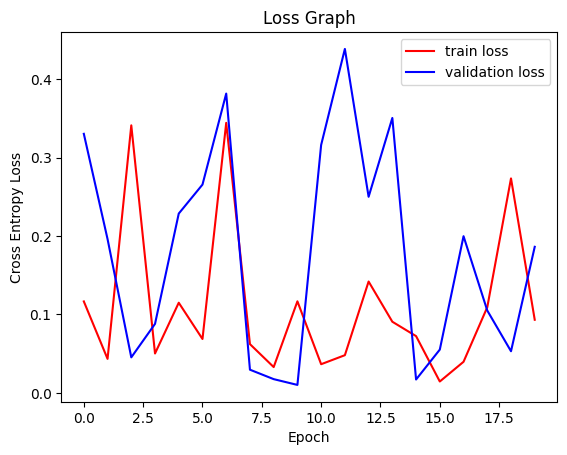

In [124]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [125]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
val_accuracies = [x/len(validation_set) for x in val_correct_predictions]

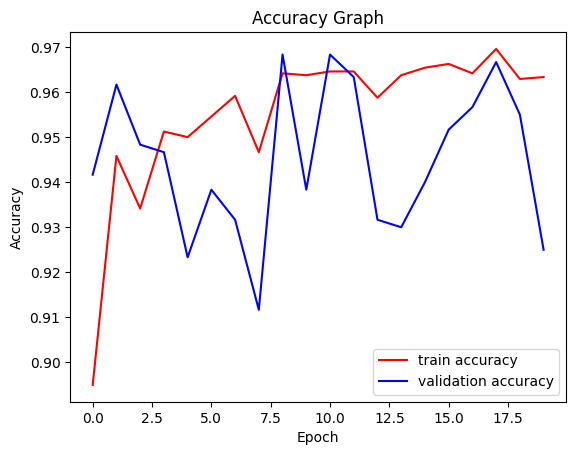

In [126]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(val_accuracies,'b',label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

### VGG 16

In [138]:
vgg16 = models.vgg16(pretrained=True)
vgg16

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [139]:
total_vgg16_params = 0

for param in vgg16.parameters():
    param.requires_grad = False
    print(param.numel())
    total_vgg16_params += param.numel()
    
print("Total VGG16 model parameters:", total_vgg16_params)

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
4096000
1000
Total VGG16 model parameters: 138357544


In [140]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,3),
    nn.LogSoftmax(dim=1)
)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [141]:
vgg16 = vgg16.cuda()

In [142]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vgg16.parameters(),lr=0.001)

start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    val_correct = 0
        
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        batch_no += 1
        y_pred = vgg16(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
         
        optimizer.zero_grad() # Reset the gradients to zero for each mini-training batch
        loss.backward() # Compute gradient of the loss by performing backpropagation
        optimizer.step() # Update the model parameters
        
        if batch_no % 10 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
        
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
        
    with torch.no_grad():    
        for batch_no, (X_val, y_val) in enumerate(val_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = vgg16(X_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
        
    loss = criterion(y_pred,y_val)
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())

print(f"Total time elapsed in VGG16 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 10 -> Loss: 0.6494942307472229
Epoch 1 Batch 20 -> Loss: 0.20623786747455597
Epoch 1 Batch 30 -> Loss: 0.17703722417354584
Epoch 1 Batch 40 -> Loss: 0.11936617642641068
Epoch 1 Batch 50 -> Loss: 0.025927746668457985
Epoch 1 Batch 60 -> Loss: 0.08255854994058609
Epoch 1 Batch 70 -> Loss: 0.0723593682050705
Epoch 2 Batch 10 -> Loss: 0.11779557168483734
Epoch 2 Batch 20 -> Loss: 0.1254260092973709
Epoch 2 Batch 30 -> Loss: 0.042849019169807434
Epoch 2 Batch 40 -> Loss: 0.07157693803310394
Epoch 2 Batch 50 -> Loss: 0.17431867122650146
Epoch 2 Batch 60 -> Loss: 0.06261415034532547
Epoch 2 Batch 70 -> Loss: 0.38934075832366943
Epoch 3 Batch 10 -> Loss: 0.1876164823770523
Epoch 3 Batch 20 -> Loss: 0.16895607113838196
Epoch 3 Batch 30 -> Loss: 0.1280623972415924
Epoch 3 Batch 40 -> Loss: 0.1873510777950287
Epoch 3 Batch 50 -> Loss: 0.3208833932876587
Epoch 3 Batch 60 -> Loss: 0.2375829666852951
Epoch 3 Batch 70 -> Loss: 0.2687838673591614
Epoch 4 Batch 10 -> Loss: 0.0590781681239

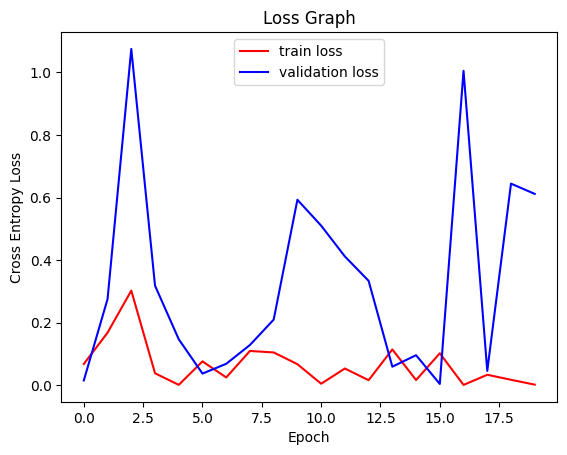

In [143]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [144]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
val_accuracies = [x/len(validation_set) for x in val_correct_predictions]

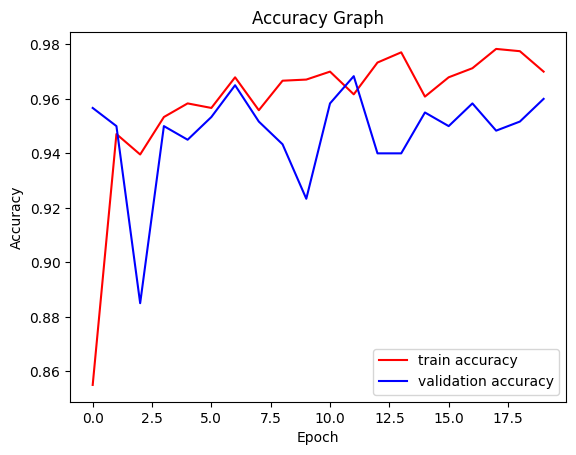

In [145]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(val_accuracies,'b',label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

### EfficientNet b3

In [146]:
efficientnet_b3 = models.efficientnet_b3(pretrained=True)
efficientnet_b3

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 165MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [147]:
total_efficientnet_params = 0

for param in efficientnet_b3.parameters():
    param.requires_grad = False
    print(param.numel())
    total_efficientnet_params += param.numel()
    
print("Total EfficientNet b3 model parameters:",total_efficientnet_params)

1080
40
40
360
40
40
400
10
400
40
960
24
24
216
24
24
144
6
144
24
576
24
24
3456
144
144
1296
144
144
864
6
864
144
4608
32
32
6144
192
192
1728
192
192
1536
8
1536
192
6144
32
32
6144
192
192
1728
192
192
1536
8
1536
192
6144
32
32
6144
192
192
4800
192
192
1536
8
1536
192
9216
48
48
13824
288
288
7200
288
288
3456
12
3456
288
13824
48
48
13824
288
288
7200
288
288
3456
12
3456
288
13824
48
48
13824
288
288
2592
288
288
3456
12
3456
288
27648
96
96
55296
576
576
5184
576
576
13824
24
13824
576
55296
96
96
55296
576
576
5184
576
576
13824
24
13824
576
55296
96
96
55296
576
576
5184
576
576
13824
24
13824
576
55296
96
96
55296
576
576
5184
576
576
13824
24
13824
576
55296
96
96
55296
576
576
14400
576
576
13824
24
13824
576
78336
136
136
110976
816
816
20400
816
816
27744
34
27744
816
110976
136
136
110976
816
816
20400
816
816
27744
34
27744
816
110976
136
136
110976
816
816
20400
816
816
27744
34
27744
816
110976
136
136
110976
816
816
20400
816
816
27744
34
27744
816
110976
136
136

In [148]:
efficientnet_b3.classifier = nn.Sequential(
    nn.Linear(1536,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,3),
    nn.LogSoftmax(dim=1)
)
efficientnet_b3

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [149]:
efficientnet_b3 = efficientnet_b3.cuda()

In [150]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=efficientnet_b3.parameters(),lr=0.001)

start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    val_correct = 0
        
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        batch_no += 1
        y_pred = efficientnet_b3(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
         
        optimizer.zero_grad() # Reset the gradients to zero for each mini-training batch
        loss.backward() # Compute gradient of the loss by performing backpropagation
        optimizer.step() # Update the model parameters
        
        if batch_no % 10 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
        
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
        
    with torch.no_grad():    
        for batch_no, (X_val, y_val) in enumerate(val_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = efficientnet_b3(X_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
        
    loss = criterion(y_pred,y_val)
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())

print(f"Total time elapsed in EfficientNet b3 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 10 -> Loss: 0.3426037132740021
Epoch 1 Batch 20 -> Loss: 0.2827857434749603
Epoch 1 Batch 30 -> Loss: 0.20068557560443878
Epoch 1 Batch 40 -> Loss: 0.5834922194480896
Epoch 1 Batch 50 -> Loss: 0.09875820577144623
Epoch 1 Batch 60 -> Loss: 0.0713857039809227
Epoch 1 Batch 70 -> Loss: 0.17274993658065796
Epoch 2 Batch 10 -> Loss: 0.07850857079029083
Epoch 2 Batch 20 -> Loss: 0.042664784938097
Epoch 2 Batch 30 -> Loss: 0.19916148483753204
Epoch 2 Batch 40 -> Loss: 0.05800618976354599
Epoch 2 Batch 50 -> Loss: 0.09824339300394058
Epoch 2 Batch 60 -> Loss: 0.09231472760438919
Epoch 2 Batch 70 -> Loss: 0.1803298145532608
Epoch 3 Batch 10 -> Loss: 0.2419053316116333
Epoch 3 Batch 20 -> Loss: 0.061738088726997375
Epoch 3 Batch 30 -> Loss: 0.1827307492494583
Epoch 3 Batch 40 -> Loss: 0.17297928035259247
Epoch 3 Batch 50 -> Loss: 0.08897052705287933
Epoch 3 Batch 60 -> Loss: 0.028964288532733917
Epoch 3 Batch 70 -> Loss: 0.06810744851827621
Epoch 4 Batch 10 -> Loss: 0.3071675300598

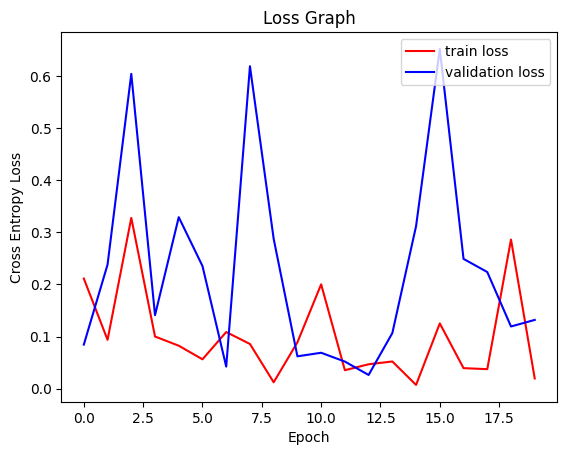

In [151]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [152]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
val_accuracies = [x/len(validation_set) for x in val_correct_predictions]

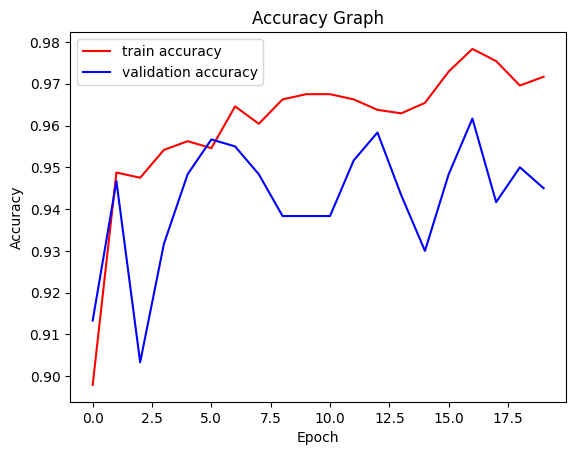

In [153]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(val_accuracies,'b',label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

### MobileNet v3 large

In [154]:
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_large

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 129MB/s] 


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [155]:
total_mobilenet_params = 0

for param in mobilenet_v3_large.parameters():
    param.requires_grad = False
    print(param.numel())
    total_mobilenet_params += param.numel()
    
print("Total MobileNetv3 large model parameters:", total_mobilenet_params)

432
16
16
144
16
16
256
16
16
1024
64
64
576
64
64
1536
24
24
1728
72
72
648
72
72
1728
24
24
1728
72
72
1800
72
72
1728
24
1728
72
2880
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
9600
240
240
2160
240
240
19200
80
80
16000
200
200
1800
200
200
16000
80
80
14720
184
184
1656
184
184
14720
80
80
14720
184
184
1656
184
184
14720
80
80
38400
480
480
4320
480
480
57600
120
57600
480
53760
112
112
75264
672
672
6048
672
672
112896
168
112896
672
75264
112
112
75264
672
672
16800
672
672
112896
168
112896
672
107520
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
1228800
1280
1280000
1000
Total MobileNetv3 large model parameters: 5483032


In [156]:
mobilenet_v3_large.classifier = nn.Sequential(
    nn.Linear(960,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,3),
    nn.LogSoftmax(dim=1)
)
mobilenet_v3_large

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [157]:
mobilenet_v3_large = mobilenet_v3_large.cuda()

In [158]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=mobilenet_v3_large.parameters(),lr=0.001)

start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    val_correct = 0
    
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        batch_no += 1
        y_pred = mobilenet_v3_large(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
         
        optimizer.zero_grad() # Reset the gradients to zero for each mini-training batch
        loss.backward() # Compute gradient of the loss by performing backpropagation
        optimizer.step() # Update the model parameters
        
        if batch_no % 10 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
        
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():    
        for batch_no, (X_val, y_val) in enumerate(val_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = mobilenet_v3_large(X_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
        
    loss = criterion(y_pred,y_val)
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())

print(f"Total time elapsed in MobileNet v3 large model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 10 -> Loss: 0.39646056294441223
Epoch 1 Batch 20 -> Loss: 0.19875065982341766
Epoch 1 Batch 30 -> Loss: 0.1899958848953247
Epoch 1 Batch 40 -> Loss: 0.1243649497628212
Epoch 1 Batch 50 -> Loss: 0.09099612385034561
Epoch 1 Batch 60 -> Loss: 0.18600311875343323
Epoch 1 Batch 70 -> Loss: 0.07233934849500656
Epoch 2 Batch 10 -> Loss: 0.27771449089050293
Epoch 2 Batch 20 -> Loss: 0.10564660280942917
Epoch 2 Batch 30 -> Loss: 0.05079023912549019
Epoch 2 Batch 40 -> Loss: 0.06606101244688034
Epoch 2 Batch 50 -> Loss: 0.23124119639396667
Epoch 2 Batch 60 -> Loss: 0.19835232198238373
Epoch 2 Batch 70 -> Loss: 0.21669092774391174
Epoch 3 Batch 10 -> Loss: 0.0410967655479908
Epoch 3 Batch 20 -> Loss: 0.048692941665649414
Epoch 3 Batch 30 -> Loss: 1.045821189880371
Epoch 3 Batch 40 -> Loss: 0.14715351164340973
Epoch 3 Batch 50 -> Loss: 0.0318448543548584
Epoch 3 Batch 60 -> Loss: 0.1825321912765503
Epoch 3 Batch 70 -> Loss: 0.048396237194538116
Epoch 4 Batch 10 -> Loss: 0.13686449825

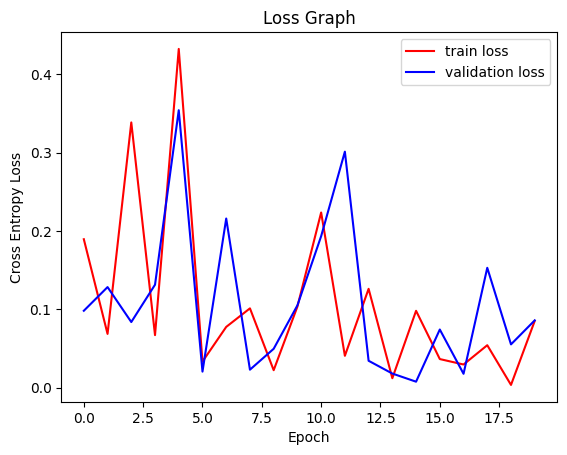

In [159]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [160]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
val_accuracies = [x/len(validation_set) for x in val_correct_predictions]

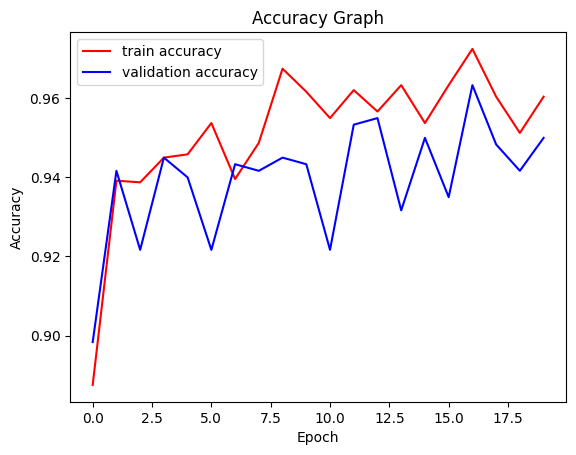

In [161]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(val_accuracies,'b',label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

### ResNet 50

In [92]:
resnet50 = models.resnet50(pretrained=True)
resnet50

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [93]:
total_resnet_params = 0

for param in resnet50.parameters():
    param.requires_grad = False
    print(param.numel())
    total_resnet_params += param.numel()
    
print("Total ResNet50 model parameters:", total_resnet_params)

9408
64
64
4096
64
64
36864
64
64
16384
256
256
16384
256
256
16384
64
64
36864
64
64
16384
256
256
16384
64
64
36864
64
64
16384
256
256
32768
128
128
147456
128
128
65536
512
512
131072
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
131072
256
256
589824
256
256
262144
1024
1024
524288
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
524288
512
512
2359296
512
512
1048576
2048
2048
2097152
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
2048000
1000
Total ResNet50 model parameters: 25557032


In [94]:
resnet50.fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,3),
    nn.LogSoftmax(dim=1)
)
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [95]:
resnet50 = resnet50.cuda()
next(resnet50.parameters()).is_cuda

True

In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50.parameters(),lr=0.001)

start_time = time.time()

epochs = 20

train_losses = []
val_losses = []
train_correct_predictions = []
val_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    val_correct = 0
    
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        batch_no += 1
        y_pred = resnet50(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
         
        optimizer.zero_grad() # Reset the gradients to zero for each mini-training batch
        loss.backward() # Compute gradient of the loss by performing backpropagation
        optimizer.step() # Update the model parameters
        
        if batch_no % 10 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
        
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    with torch.no_grad():    
        for batch_no, (X_val, y_val) in enumerate(val_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = resnet50(X_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum()
        
    loss = criterion(y_pred,y_val)
    val_losses.append(loss.item())
    val_correct_predictions.append(val_correct.item())

print(f"Total time elapsed in ResNet50 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 10 -> Loss: 0.3634237051010132
Epoch 1 Batch 20 -> Loss: 0.23218321800231934
Epoch 1 Batch 30 -> Loss: 0.08138077706098557
Epoch 1 Batch 40 -> Loss: 0.06124744191765785
Epoch 1 Batch 50 -> Loss: 0.1009175181388855
Epoch 1 Batch 60 -> Loss: 0.11137706786394119
Epoch 1 Batch 70 -> Loss: 0.09037499874830246
Epoch 2 Batch 10 -> Loss: 0.09235760569572449
Epoch 2 Batch 20 -> Loss: 0.24329093098640442
Epoch 2 Batch 30 -> Loss: 0.16026800870895386
Epoch 2 Batch 40 -> Loss: 0.07188411056995392
Epoch 2 Batch 50 -> Loss: 0.3270312249660492
Epoch 2 Batch 60 -> Loss: 0.11016183346509933
Epoch 2 Batch 70 -> Loss: 0.11447925120592117
Epoch 3 Batch 10 -> Loss: 0.1765686720609665
Epoch 3 Batch 20 -> Loss: 0.0706239715218544
Epoch 3 Batch 30 -> Loss: 0.020203430205583572
Epoch 3 Batch 40 -> Loss: 0.023934094235301018
Epoch 3 Batch 50 -> Loss: 0.019623754546046257
Epoch 3 Batch 60 -> Loss: 0.11403634399175644
Epoch 3 Batch 70 -> Loss: 0.4733806550502777
Epoch 4 Batch 10 -> Loss: 0.210472613

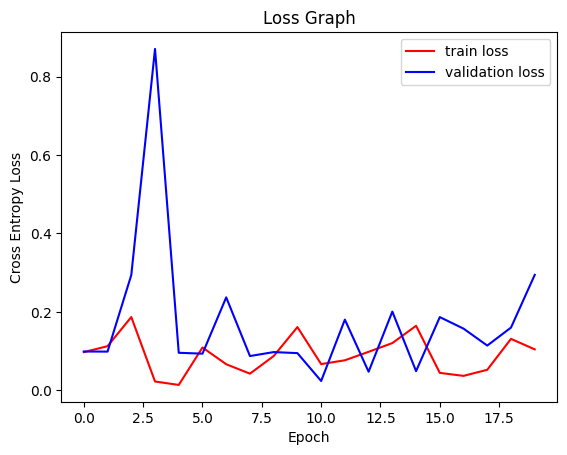

In [97]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(val_losses,'b',label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [98]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
val_accuracies = [x/len(validation_set) for x in val_correct_predictions]

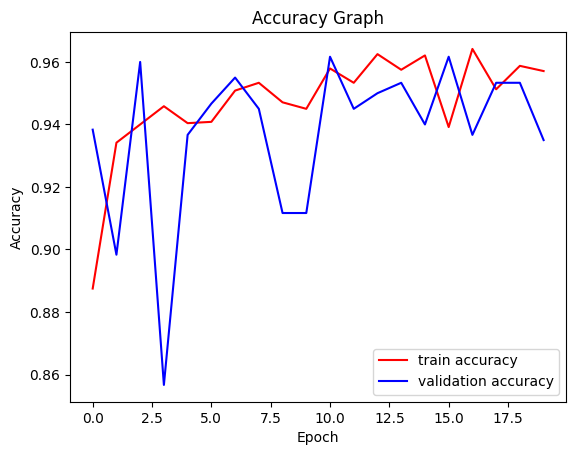

In [99]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(val_accuracies,'b',label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

Among all the pretrained models, the Mobile Net v3 large classifier seems to be the most computationally efficient model as it offers comparable performance with SOTA models like ResNet50, VGG16, etc. So, it is the most suitable and optimal choice for deployment purposes.

In [162]:
torch.save(mobilenet_v3_large,'cat_dog_snake_mobilenet_classifier.pt')